In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import TextBoxesProcessor

In [2]:
# 加载图像
image_path = '/Users/jiazhengtian/Desktop/image.png'
image = cv2.imread(image_path)

In [3]:
textprocessor = TextBoxesProcessor.TextBoxesDetector(image_path, distance_threshold=40)

[2025/03/27 22:10:03] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/jiazhengtian/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/jiazhengtian/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

In [4]:
textprocessor.image.shape

(214, 458, 3)

In [5]:
dict, boxes_loc = textprocessor.combined_dict()

In [6]:
dict

{((np.int32(112), np.int32(11)),
  (np.int32(188), np.int32(11)),
  (np.int32(188), np.int32(21)),
  (np.int32(112), np.int32(21))): 'Contentment',
 ((np.int32(102), np.int32(54)),
  (np.int32(198), np.int32(54)),
  (np.int32(198), np.int32(67)),
  (np.int32(102), np.int32(67))): 'Family & Friends',
 ((np.int32(53), np.int32(97)),
  (np.int32(91), np.int32(100)),
  (np.int32(90), np.int32(115)),
  (np.int32(52), np.int32(112))): 'Safety',
 ((np.int32(177), np.int32(99)),
  (np.int32(281), np.int32(99)),
  (np.int32(281), np.int32(113)),
  (np.int32(177), np.int32(113))): 'Work/Life Balance',
 ((np.int32(59), np.int32(145)),
  (np.int32(85), np.int32(145)),
  (np.int32(85), np.int32(160)),
  (np.int32(59), np.int32(160))): 'ot',
 ((np.int32(196), np.int32(143)),
  (np.int32(262), np.int32(145)),
  (np.int32(261), np.int32(160)),
  (np.int32(195), np.int32(157))): 'Admiration',
 ((np.int32(352), np.int32(146)),
  (np.int32(420), np.int32(146)),
  (np.int32(420), np.int32(160)),
  (np.int

In [7]:
boxes_loc

[(np.int32(185), np.int32(191), np.int32(271), np.int32(205))]

In [8]:
def find_box(image_path):
    image = cv2.imread(image_path)

    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 二值化处理
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # 查找轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 形态学操作（分离相邻的框和线）
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)  # 去除噪声
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)  # 连接断开的区域

    # 检测文本框
    get_boxes = []  # 存储文本框坐标
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h > 1000:  # 假设文本框面积较大
            get_boxes.append((x, y, x + w, y + h))
    
    return get_boxes

In [9]:
find_box(image_path)

[(157, 183, 301, 212),
 (313, 137, 457, 167),
 (157, 137, 301, 166),
 (0, 137, 144, 166),
 (157, 91, 301, 121),
 (0, 91, 143, 121),
 (0, 0, 458, 214)]

In [10]:
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    # 计算交集
    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    
    # 计算IOU
    iou_score = inter_area / float(box1_area + box2_area - inter_area)
    return iou_score

In [11]:
defined_boxes = find_box(image_path)

def filter_box(image_path, line_boxes, boxes_loc):
    boxes = line_boxes if line_boxes else boxes_loc

    filtered_boxes = []
    for i, box1 in enumerate(boxes):
        keep = True
        for j, box2 in enumerate(boxes):
            if i != j and iou(box1, box2) > 0.4:  # 如果两个框高度重叠
                if (box1[2] - box1[0]) * (box1[3] - box1[1]) > (box2[2] - box2[0]) * (box2[3] - box2[1]):
                    keep = False  # 保留面积较小的框
        if keep:
            filtered_boxes.append(box1)
    
    for box in filtered_boxes:
        x1, y1, _, _ = box
        if x1 == 0 and y1 == 0:
            filtered_boxes.remove(box)
            
    return filtered_boxes

In [12]:
filtered_boxes = filter_box(image_path, defined_boxes, boxes_loc)

[(157, 183, 301, 212), (313, 137, 457, 167), (157, 137, 301, 166), (0, 137, 144, 166), (157, 91, 301, 121), (0, 91, 143, 121)]


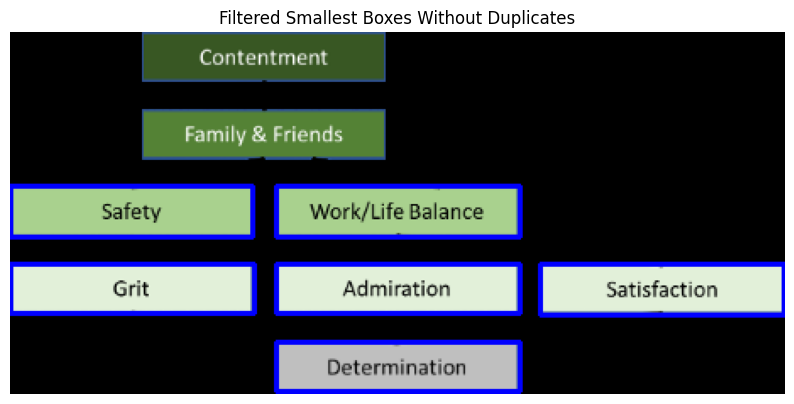

In [13]:
if __name__ == '__main__':
    filtered_boxes = filter_box(image_path, defined_boxes, boxes_loc)
    print(filtered_boxes)

    # 5. 绘制最终文本框
    for box in filtered_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 画蓝色框

    # 6. 显示最终的检测结果
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title("Filtered Smallest Boxes Without Duplicates")
    plt.axis("off")
    plt.show()